In [1]:
import boto3
import pandas as pd
from hatchet_sdk import new_client
from pydantic import AnyUrl

from epengine.models.shoebox import ShoeboxSimulationSpec

spec = ShoeboxSimulationSpec(
    experiment_id="test",
    sort_index=0,
    lib_uri=AnyUrl("s3://ml-for-bem/tiles/massachusetts/2024_09_30/everett_lib.json"),
    typology="Residential",
    year_built=1972,
    num_floors=3,
    neighbor_polys=["POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))"],
    neighbor_floors=[3],
    rotated_rectangle="POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))",
    rotated_rectangle_area_ratio=1,
    long_edge=10,
    short_edge=10,
    long_edge_angle=0.23,
    footprint_area=100,
    epwzip_path="https://climate.onebuilding.org/WMO_Region_4_North_and_Central_America/USA_United_States_of_America/MA_Massachusetts/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2009-2023.zip",
)
specs = [spec.model_dump(mode="json")] * 1000
df = pd.DataFrame(specs)
df.to_parquet("shoebox_specs.parquet")
s3 = boto3.client("s3")
s3.upload_file(
    "shoebox_specs.parquet", "ml-for-bem", "hatchet/pq-test/shoebox_specs.parquet"
)
uri = "s3://ml-for-bem/hatchet/pq-test/shoebox_specs.parquet"
df

,experiment_id,sort_index,lib_uri,typology,year_built,num_floors,rotated_rectangle,neighbor_polys,neighbor_floors,epwzip_path,footprint_area,long_edge_angle,long_edge,short_edge,rotated_rectangle_area_ratio
0,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0
1,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0
2,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0
3,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0
4,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0
996,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0
997,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0
998,test,0,s3://ml-for-bem/tiles/massachusetts/2024_09_30...,Residential,1972,3,"POLYGON ((5 0, 5 10, 15 10, 15 0, 5 0))","[POLYGON ((-10 0, -10 10, -5 10, -5 0, -10 0))]",[3.0],https://climate.onebuilding.org/WMO_Region_4_N...,100.0,0.23,10.0,10.0,1.0


In [2]:
client = new_client()

payload = {
    "workflow_name": "simulate_ubem_shoebox",
    "experiment_id": "test-shoebox-recurse",
    "bucket": "ml-for-bem",
    "specs": uri,
    "recursion_map": {"factor": 5, "max_depth": 1},
}
client.admin.run_workflow("scatter_gather_recursive", payload)

In [1]:
import boto3
import pandas as pd

s3 = boto3.client("s3")

s3.download_file(
    Bucket="ml-for-bem",
    Filename="s.pq",
    Key="tiles/massachusetts/2024_09_30/sim_specs.pq",
)

df = pd.read_parquet("s.pq")

# View some results

<Axes: >

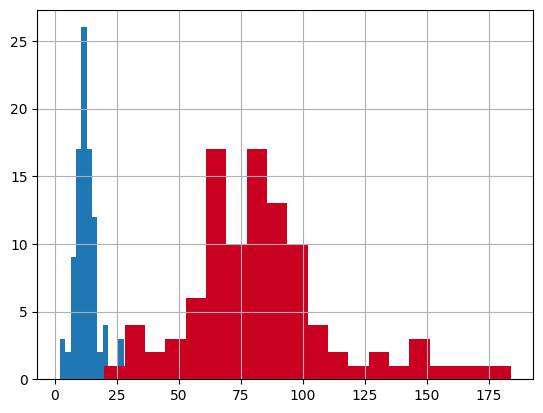

In [18]:
import boto3
import pandas as pd

client = boto3.client("s3")
bucket = "ml-for-bem"
key = "hatchet/massachusetts/2024_09_30/residential2/results/2245f99c-d69e-400a-bda5-12359f54ec30.h5"
client.download_file(bucket, key, "cache/results.h5")
df = pd.read_hdf("cache/results.h5")
df.round()["District Cooling"].hist(bins=20)
df.round()["District Heating"].hist(bins=20, color="#ca0020")

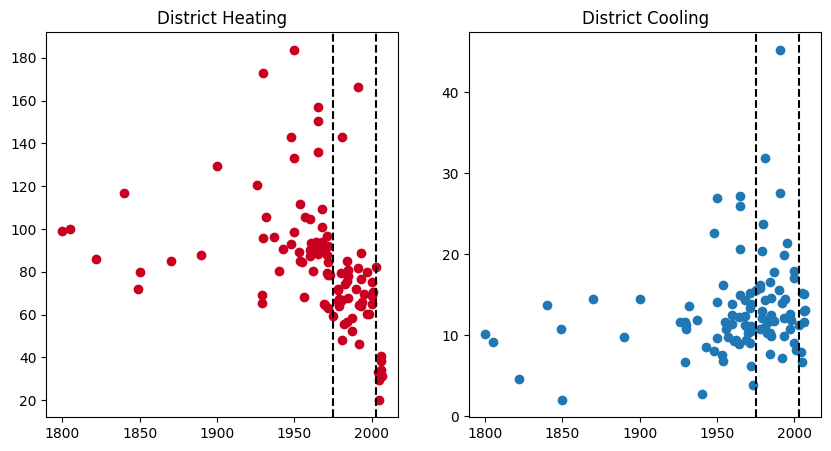

In [20]:
import matplotlib.pyplot as plt

(
    fig,
    ax,
) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
heating = df["District Heating"]
cooling = df["District Cooling"]
yr_built = df.index.get_level_values("year_built")
ax[0].scatter(yr_built, heating, label="District Heating", color="#ca0020")
ax[0].set_title("District Heating")
ax[1].scatter(yr_built, cooling, label="District Cooling")
ax[1].set_title("District Cooling")
ax[1].axvline(1975, color="black", linestyle="--")
ax[0].axvline(1975, color="black", linestyle="--")
ax[1].axvline(2003, color="black", linestyle="--")
ax[0].axvline(2003, color="black", linestyle="--")